In [9]:
import argparse
import math

import gymnasium as gym
import pyglet
from pyglet.window import key

import miniworld
from tqdm import tqdm

import numpy as np
from itertools import count
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
from miniworld.wrappers import PyTorchObsWrapper,GreyscaleWrapper

cuda


In [10]:
miniworld.envs.env_ids

['MiniWorld-CollectHealth-v0',
 'MiniWorld-FourRooms-v0',
 'MiniWorld-Hallway-v0',
 'MiniWorld-Maze-v0',
 'MiniWorld-MazeS2-v0',
 'MiniWorld-MazeS3-v0',
 'MiniWorld-MazeS3Fast-v0',
 'MiniWorld-OneRoom-v0',
 'MiniWorld-OneRoomS6-v0',
 'MiniWorld-OneRoomS6Fast-v0',
 'MiniWorld-PickupObjects-v0',
 'MiniWorld-PutNext-v0',
 'MiniWorld-RoomObjects-v0',
 'MiniWorld-Sidewalk-v0',
 'MiniWorld-Sign-v0',
 'MiniWorld-TMaze-v0',
 'MiniWorld-TMazeLeft-v0',
 'MiniWorld-TMazeRight-v0',
 'MiniWorld-ThreeRooms-v0',
 'MiniWorld-WallGap-v0',
 'MiniWorld-YMaze-v0',
 'MiniWorld-YMazeLeft-v0',
 'MiniWorld-YMazeRight-v0']

In [11]:
env = gym.make('MiniWorld-Hallway-v0', length = 15, view="agent", render_mode=None)
env = PyTorchObsWrapper(env)

In [38]:

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()

        self.hidden_size = 32

        self.conv1 = nn.Conv2d(3, 16, 3, stride=2).to(device)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2).to(device)
        self.maxpool = nn.MaxPool2d(2).to(device)

        self.outconvsize = 2016
        self.affine1 = nn.Linear( self.outconvsize , self.hidden_size).to(device) 

        ###replacement for rnn
         
        self.rnn = nn.RNN(self.outconvsize, self.hidden_size,batch_first=True).to(device)
        self.hidden_state = torch.zeros(1, 1, self.hidden_size).to(device)

        self.action_head = nn.Sequential(
                                    nn.Linear(self.hidden_size, self.hidden_size).to(device),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, 3).to(device)
                                ).to(device)

        self.value_head = nn.Sequential(
                                    nn.Linear(self.hidden_size, self.hidden_size).to(device),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, 1).to(device)
                                ).to(device)

        self.saved_log_probs = []
        self.rewards = []
        self.batch_loss = []

        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()

    def reset_hidden_state(self):
        self.hidden_state = torch.zeros(1, 1, self.hidden_size).to(device)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = x.reshape(-1,self.outconvsize)
        # x = self.relu(self.affine1(x))
        h = self.rnn(x.unsqueeze(0), self.hidden_state)[1]
        self.hidden_state = h
        out = h.squeeze(0)
        action_prob = F.softmax(self.action_head(out), dim=-1)
        state_value = self.value_head(out)
        return action_prob, state_value


policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
eps = np.finfo(np.float32).eps.item()

def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs,state_value = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append( (m.log_prob(action), state_value) )

    return action.item(),probs
    
gamma = 1

def finish_episode():
    R = 0
    policy_loss = []
    value_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns).to(device)
    # returns = (returns - returns.mean()) / (returns.std() + eps) # this create error ...
    for (log_prob,value), R in zip(policy.saved_log_probs, returns):
        advantage = R - value.item()
        policy_loss.append(-log_prob * advantage)
        value_loss.append(F.smooth_l1_loss(value, torch.tensor([R]).to(device)))
    loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()
    policy.batch_loss.append(loss)
    del policy.rewards[:]
    del policy.saved_log_probs[:]
    policy.reset_hidden_state()


def finish_batch():
    optimizer.zero_grad()
    loss = torch.stack(policy.batch_loss).sum()
    loss.backward()
    optimizer.step()
    del policy.batch_loss[:]
    return loss.item()


In [39]:
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
count_parameters(policy)

137476

In [40]:
#you need at least 3000 episodes to get a good training
def main():
    running_reward = 0
    for i_episode in range(3000):
        state, _ = env.reset()
        ep_reward = 0
        for t in range(1, 100):  # Don't infinite loop while learning
            action,show_prob = select_action(state)
            state, reward, done, _, _ = env.step(action)
            #if args.render:
            #    env.render()
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        if i_episode % 1 == 0:
            loss = finish_batch()
            print(loss,show_prob.cpu().detach().numpy()[0])
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))


In [41]:
main()

C:\Users\fphub\AppData\Local\Temp\ipykernel_40460\191979624.py:83: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss.append(F.smooth_l1_loss(value, torch.tensor([R]).to(device)))


8.703564643859863 [0.29108763 0.34326333 0.36564904]
Episode 0	Last reward: 0.00	Average reward: 0.00
-8.304718971252441 [0.28448424 0.29440126 0.42111444]
Episode 1	Last reward: 0.00	Average reward: 0.00
100.06692504882812 [0.25893903 0.33290732 0.40815365]
Episode 2	Last reward: 0.93	Average reward: 0.05
-11.605867385864258 [0.26182094 0.35530034 0.3828788 ]
Episode 3	Last reward: 0.00	Average reward: 0.04
-9.770737648010254 [0.2410297 0.3978404 0.3611299]
Episode 4	Last reward: 0.00	Average reward: 0.04
-6.399415969848633 [0.24181344 0.3992659  0.35892075]
Episode 5	Last reward: 0.00	Average reward: 0.04
-5.731701374053955 [0.24369524 0.3996333  0.35667148]
Episode 6	Last reward: 0.00	Average reward: 0.04
-5.644887924194336 [0.24304113 0.4024632  0.35449564]
Episode 7	Last reward: 0.00	Average reward: 0.04
-5.453060626983643 [0.24268128 0.40260285 0.35471585]
Episode 8	Last reward: 0.00	Average reward: 0.03
108.03473663330078 [0.24234523 0.40610957 0.35154524]
Episode 9	Last reward:

KeyboardInterrupt: 

In [ ]:
# torch.save(policy.state_dict(), 'miniworld_001.pt')

In [ ]:
#policy = Policy().to(device)
#policy.load_state_dict(torch.load('miniworld_001.pt'))

<All keys matched successfully>

In [42]:
env = gym.make('MiniWorld-Hallway-v0', length = 15, view="agent", render_mode="human")
env = PyTorchObsWrapper(env)

import timeit
class CodeTimer:
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start) * 1000.0
        print('Code block' + self.name + ' took: ' + str(self.took) + ' ms')


observation, info = env.reset()

# Create the display window
env.render()

for _ in range(100):
    action,probs = select_action(observation) # agent policy that uses the observation and info
    print(probs)
    observation, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        print('over')
        observation, info = env.reset()
env.close()

tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.3281, 0.3659, 0.3061]], devic

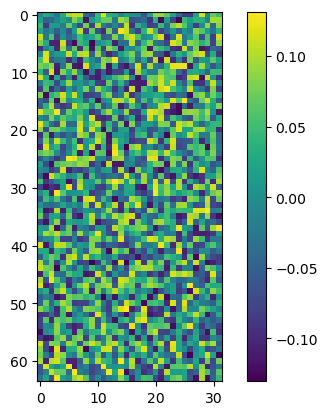

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(policy.rnn.all_weights[0][0].cpu().detach().numpy())
plt.colorbar()
plt.show()

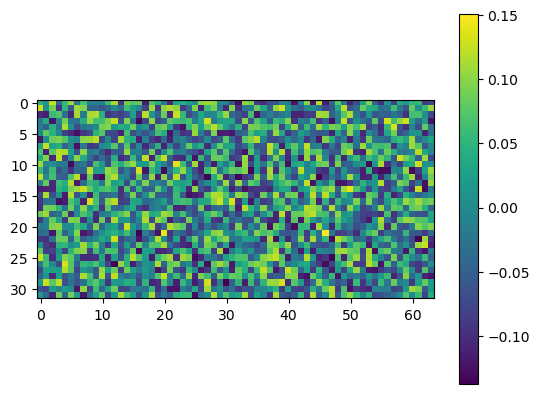

In [ ]:
policy.value_head[0].weight
plt.imshow(policy.action_head[0].weight.cpu().detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
for name,part in policy.named_parameters():
    print(name)
    print(part)

conv1.weight
Parameter containing:
tensor([[[[ 0.0909,  0.0526,  0.0434],
          [ 0.1469,  0.1431,  0.1363],
          [-0.1325,  0.1157,  0.1612]],

         [[-0.1238,  0.0926, -0.1305],
          [-0.0497, -0.1625,  0.1114],
          [-0.0855, -0.0589, -0.1628]],

         [[ 0.0964, -0.1817, -0.1878],
          [ 0.1397, -0.0476, -0.0308],
          [-0.1384,  0.0046, -0.1778]]],


        [[[ 0.0451, -0.1815,  0.0449],
          [ 0.1248,  0.0254, -0.1466],
          [-0.1097, -0.1756, -0.0633]],

         [[-0.0200, -0.0180,  0.0646],
          [-0.0897, -0.0535,  0.0898],
          [ 0.1548,  0.0268,  0.1644]],

         [[ 0.1919,  0.1545, -0.1441],
          [-0.0143, -0.1802, -0.1436],
          [ 0.0761, -0.1296, -0.0731]]],


        [[[ 0.0320,  0.1830, -0.0200],
          [-0.0664,  0.1091,  0.0050],
          [-0.0804,  0.1314, -0.1492]],

         [[-0.2139, -0.1127,  0.0073],
          [ 0.0413, -0.0056, -0.0190],
          [-0.0850,  0.1301, -0.0271]],

         